In [578]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pysurvival.datasets import Dataset
from pysurvival.utils.display import correlation_matrix, compare_to_actual, \
        integrated_brier_score, create_risk_groups
from pysurvival.utils.metrics import concordance_index      
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel


#%pylab inline

import warnings
warnings.filterwarnings("ignore")

#sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format


In [579]:
# load the data
df0 = Dataset("churn").load()
df0.tail(4)

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
1996,1024,Free-Trial,Active,Active,7,3,0,15,0,0,50-100,Middle Atlantic,2,1
1997,500,Free-Trial,Active,Active,8,5,0,15,0,6,10-50,West North Central,1,1
1998,500,Free-Trial,No,Active,10,6,1,15,1,3,100-250,Pacific,3,1
1999,1024,Free-Trial,Free-Trial,Free-Trial,8,5,0,18,0,0,50-100,East South Central,4,1


In [580]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   product_data_storage             2000 non-null   int64  
 1   product_travel_expense           2000 non-null   object 
 2   product_payroll                  2000 non-null   object 
 3   product_accounting               2000 non-null   object 
 4   csat_score                       2000 non-null   int64  
 5   articles_viewed                  2000 non-null   int64  
 6   smartphone_notifications_viewed  2000 non-null   int64  
 7   marketing_emails_clicked         2000 non-null   int64  
 8   social_media_ads_viewed          2000 non-null   int64  
 9   minutes_customer_support         2000 non-null   float64
 10  company_size                     2000 non-null   object 
 11  us_region                        2000 non-null   object 
 12  months_active       

In [581]:
# any missing values?
dfgap = df0[df0.isnull().any(axis=1)]
dfgap

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned


In [582]:
# review the numerical values
df0.describe()

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned
count,"2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,000"
mean,"1,400",9,4,0,16,0,2,4,0
std,"1,210",1,2,1,3,1,7,2,0
min,100,5,0,0,7,0,0,0,0
25%,500,8,3,0,14,0,0,2,0
50%,"1,024",9,4,0,16,0,0,3,0
75%,"2,048",10,5,1,18,1,0,5,1
max,"5,120",10,14,3,26,2,58,12,1


In [583]:
# helper function: plot the numerical variables
def plot_nums(df):
    numcols = list(df.dtypes[df.dtypes != np.object].index)

    for col in numcols:
        fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))
        x = df[numcols].values

        ax1.boxplot(x)
        ax1.set_title("{}".format(col))

        ax2.hist(x, bins=20)
        ax2.set_title("{}".format(col))

        plt.show()

In [584]:
# review the numerical columns
# plot_nums(df0)

In [585]:
# review the categorical variables
df0.describe(include='object').T

,count,unique,top,freq
product_travel_expense,2000,3,Free-Trial,1608
product_payroll,2000,3,Active,934
product_accounting,2000,3,Active,1010
company_size,2000,5,10-50,690
us_region,2000,9,Mountain,235


In [607]:
# backup the original data before modifications
df1 = df0.copy()

# create numerical columns from categories via one-hot encoding
catcols = list(df1.dtypes[df1.dtypes == np.object].index)
df1 = pd.get_dummies(df1, columns=catcols, drop_first=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_data_storage               2000 non-null   int64  
 1   csat_score                         2000 non-null   int64  
 2   articles_viewed                    2000 non-null   int64  
 3   smartphone_notifications_viewed    2000 non-null   int64  
 4   marketing_emails_clicked           2000 non-null   int64  
 5   social_media_ads_viewed            2000 non-null   int64  
 6   minutes_customer_support           2000 non-null   float64
 7   months_active                      2000 non-null   float64
 8   churned                            2000 non-null   float64
 9   product_travel_expense_Free-Trial  2000 non-null   uint8  
 10  product_travel_expense_No          2000 non-null   uint8  
 11  product_payroll_Free-Trial         2000 non-null   uint8

In [588]:
df1.head(4)

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned,product_travel_expense_Free-Trial,...,company_size_50-100,company_size_self-employed,us_region_East South Central,us_region_Middle Atlantic,us_region_Mountain,us_region_New England,us_region_Pacific,us_region_South Atlantic,us_region_West North Central,us_region_West South Central
0,2048,9,4,0,14,1,8,3,1,1,...,0,0,0,0,0,0,0,0,1,0
1,2048,9,4,2,12,1,0,2,1,1,...,0,0,0,0,0,0,0,1,0,0
2,2048,9,3,2,17,1,0,7,0,0,...,0,0,1,0,0,0,0,0,0,0
3,500,10,0,0,14,0,0,8,1,0,...,1,0,1,0,0,0,0,0,0,0


In [589]:
df1.select_dtypes(exclude="object").nunique()

product_data_storage                   6
csat_score                             6
articles_viewed                       13
smartphone_notifications_viewed        4
marketing_emails_clicked              20
social_media_ads_viewed                3
minutes_customer_support             217
months_active                         13
churned                                2
product_travel_expense_Free-Trial      2
product_travel_expense_No              2
product_payroll_Free-Trial             2
product_payroll_No                     2
product_accounting_Free-Trial          2
product_accounting_No                  2
company_size_10-50                     2
company_size_100-250                   2
company_size_50-100                    2
company_size_self-employed             2
us_region_East South Central           2
us_region_Middle Atlantic              2
us_region_Mountain                     2
us_region_New England                  2
us_region_Pacific                      2
us_region_South 

In [608]:
# target variables: months_active and churns
time_column = 'months_active'
event_column = 'churned'

# list of feature columns: excluding the target columns
features = np.setdiff1d(df1.columns, [time_column, event_column] ).tolist()
X = df1[features]
X.tail(4)

,articles_viewed,company_size_10-50,company_size_100-250,company_size_50-100,company_size_self-employed,csat_score,marketing_emails_clicked,minutes_customer_support,product_accounting_Free-Trial,product_accounting_No,...,smartphone_notifications_viewed,social_media_ads_viewed,us_region_East South Central,us_region_Middle Atlantic,us_region_Mountain,us_region_New England,us_region_Pacific,us_region_South Atlantic,us_region_West North Central,us_region_West South Central
1996,3,0,0,1,0,7,15,0.000,0,0,...,0,0,0,1,0,0,0,0,0,0
1997,5,1,0,0,0,8,15,5.900,0,0,...,0,0,0,0,0,0,0,0,1,0
1998,6,0,1,0,0,10,15,3.300,0,0,...,1,1,0,0,0,0,1,0,0,0
1999,5,0,0,1,0,8,18,0.000,1,0,...,0,0,1,0,0,0,0,0,0,0


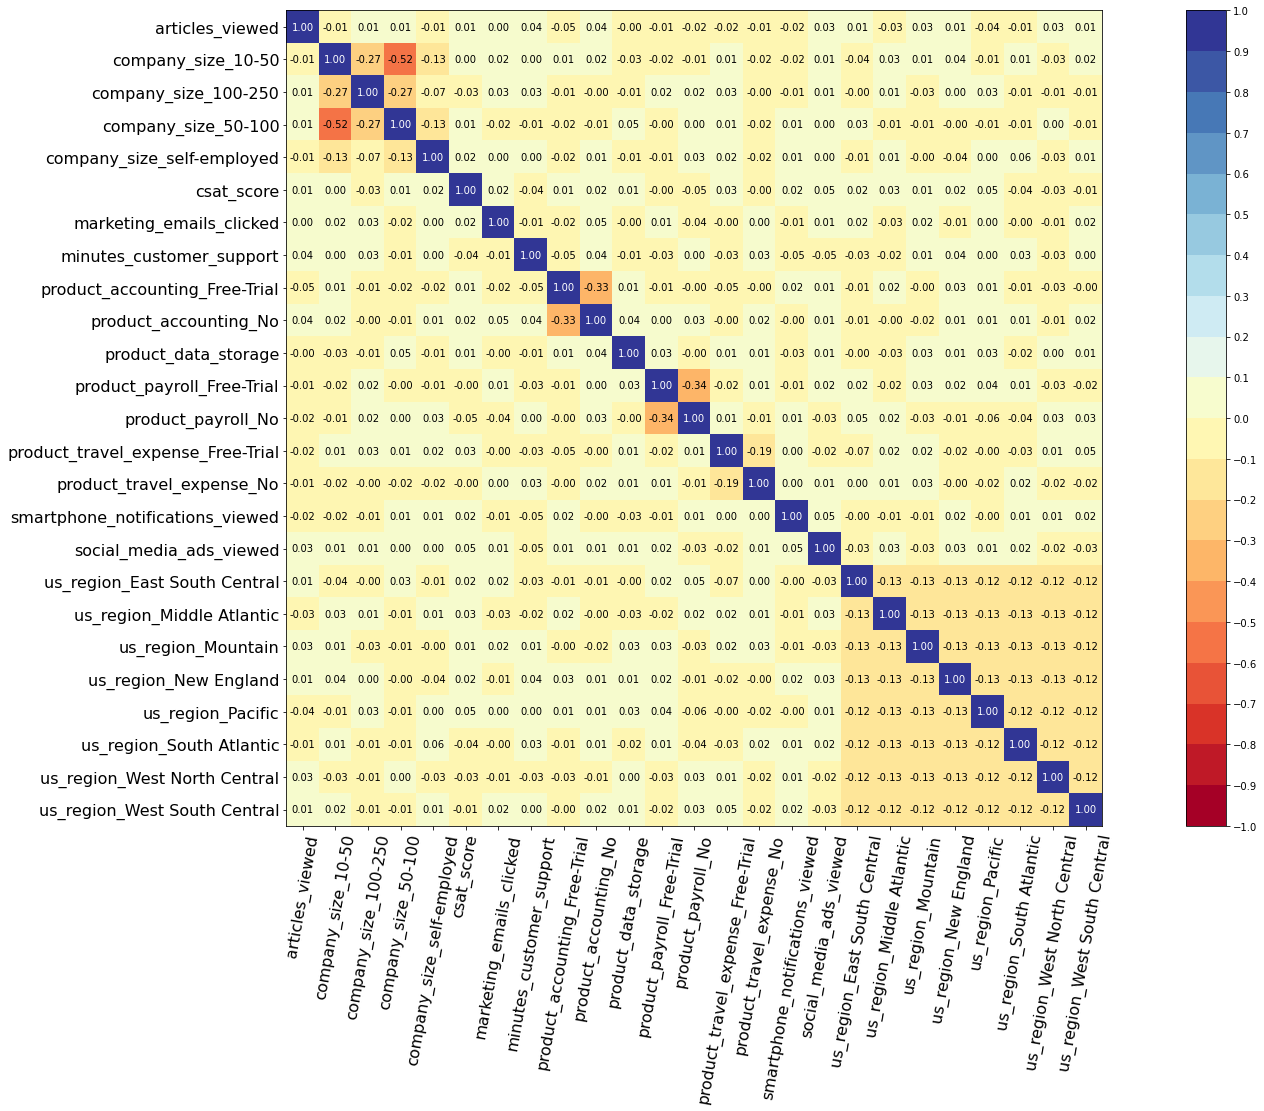

In [591]:
# correlation matrix of the features
correlation_matrix(df1[features], figure_size=(30,15), text_fontsize=10)

In [592]:
# sklearn: train vs test split
N = df1.shape[0]
idx_train, idx_test = train_test_split(range(N), test_size = 0.35)
df_train = df1.loc[idx_train].reset_index(drop = True)
df_test  = df1.loc[idx_test].reset_index(drop = True)

In [593]:
# features, times (months active), and churn events: isolate the X, T and E variables
X_train, X_test = df_train[features], df_test[features]
T_train, T_test = df_train[time_column], df_test[time_column]       # when did the Churn event occur?
E_train, E_test = df_train[event_column], df_test[event_column]     # vdid the Churn event occur?

In [594]:
# fitting a survival forest model
model = ConditionalSurvivalForestModel(num_trees=200)
model.fit(
        X_train, 
        T_train, 
        E_train, 
        max_features="sqrt",    # number of features randomly chosen at each split (int, float, "sqrt", "log2", or "all")
        max_depth=5,            #
        min_node_size=20,       # minimum number of samples at leaf node
        alpha=0.05,             # significance threshold to allow splitting 
        seed=42,                # seed for random variable generator
        sample_size_pct=0.63,   # % of original samples used in each tree building
        num_threads=-1          # number of jobs to run; if -1, then all available cores will be used
        )

ConditionalSurvivalForestModel

concordance index: 0.87


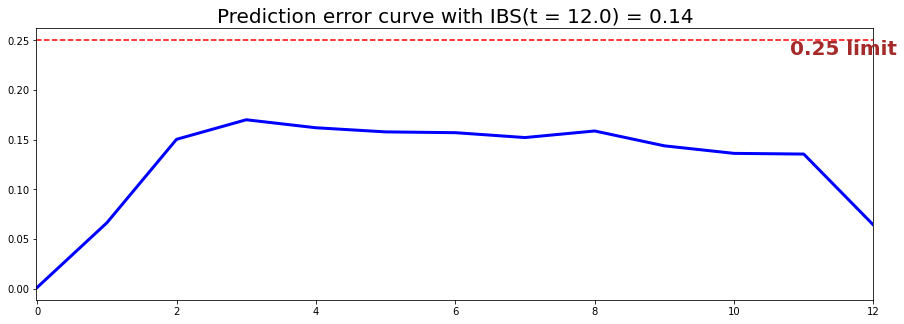

integrated Brier score: 0.14


In [595]:
# testing: model quality - prediction error measures by concordance index and Brier score
ci = concordance_index(model, X_test, T_test, E_test)
print("concordance index: {:.2f}".format(ci))

ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print("integrated Brier score: {:.2f}".format(ibs))

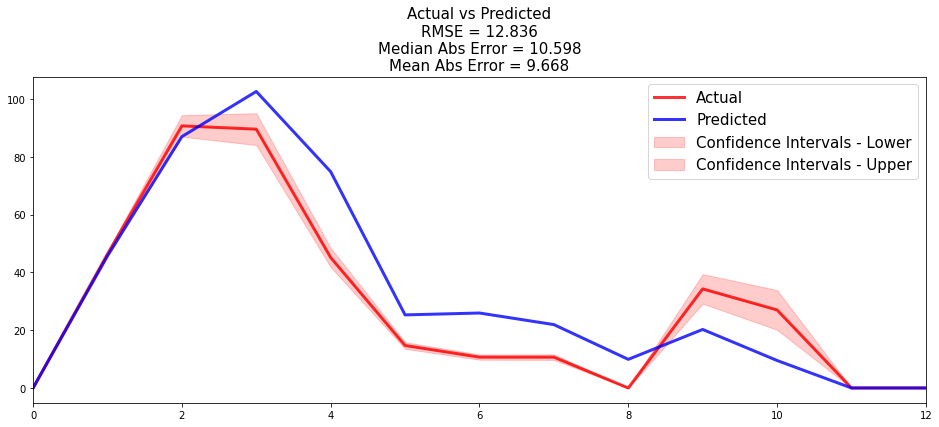

accuracy metrics:
root_mean_squared_error : 12.84
median_absolute_error : 10.60
mean_absolute_error : 9.67


In [596]:
# testing: model quality - actual vs predicted churn events
res = compare_to_actual(
            model, 
            X_test, 
            T_test, 
            E_test,
            is_at_risk = False,       # True: return the expected number of customers at risk
            figure_size=(16, 6),
            metrics = ["rmse", "mean", "median"])   # root mean square error, mean abs error, median abs error
print("accuracy metrics:")
_ = [print(k,":",f'{v:.2f}') for k,v in res.items()]

In [597]:
# model results: variable importance
# positive: increase the risk; negative: alleviate the risk
pd.options.display.float_format = '{:,.3f}'.format
model.variable_importance_table

,feature,importance,pct_importance
0,csat_score,12.815,0.204
1,product_payroll_No,11.575,0.185
2,product_accounting_No,9.520,0.152
3,minutes_customer_support,7.447,0.119
4,smartphone_notifications_viewed,3.592,0.057
5,product_travel_expense_Free-Trial,3.496,0.056
6,product_payroll_Free-Trial,3.073,0.049
7,marketing_emails_clicked,2.506,0.040
8,product_data_storage,2.026,0.032
9,company_size_100-250,1.461,0.023


In [598]:
# survival function, hazard function and risk score for a randomly drawn individual
k = np.random.choice(df1.index)

# t = number of time periods for which to show the probabilities
# if t = None, then t = maximum number of "months active" in dataset

svf = model.predict_survival(X.values[k,:], t=None)     # survival function over time
hzf = model.predict_hazard(X.values[k,:], t=None)       # hazard function over time
risk = model.predict_risk(X.values[k,:], t=None)        # risk score (scalar)

df_risk = pd.DataFrame()
df_risk["svf"] = svf.flatten().tolist()
df_risk["hzf"] = hzf.flatten().tolist()
df_risk.insert(2, "risk", risk.item())
print("risk score, and survival and hazard functions over time, for customer", k, ":")
df_risk

risk score, and survival and hazard functions over time, for customer 1989 :


,svf,hzf,risk
0,1.000,0.000,11.227
1,0.918,0.087,11.227
2,0.765,0.189,11.227
3,0.598,0.271,11.227
4,0.483,0.280,11.227
5,0.451,0.086,11.227
6,0.415,0.123,11.227
7,0.394,0.088,11.227
8,0.381,0.027,11.227
9,0.356,0.060,11.227


In [599]:
# compute every customer's survival function and risk score for 4 chosen periods (active months)
T = [1,3,6,12]
for t in T:
    svf = model.predict_survival(X.values, t=t)     # survival function over time
    df1["svf" + str(t)] = svf
df1["risk"] = model.predict_risk(X.values)            # risk score
df1.tail(4)

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned,product_travel_expense_Free-Trial,...,us_region_New England,us_region_Pacific,us_region_South Atlantic,us_region_West North Central,us_region_West South Central,svf1,svf3,svf6,svf12,risk
1996,1024,7,3,0,15,0,0.000,2.000,1.000,1,...,0,0,0,0,0,0.926,0.616,0.424,0.344,10.976
1997,500,8,5,0,15,0,5.900,1.000,1.000,1,...,0,0,0,1,0,0.917,0.593,0.404,0.329,11.733
1998,500,10,6,1,15,1,3.300,3.000,1.000,1,...,0,1,0,0,0,0.910,0.567,0.428,0.364,12.472
1999,1024,8,5,0,18,0,0.000,4.000,1.000,1,...,0,0,0,0,0,0.926,0.619,0.433,0.352,10.756


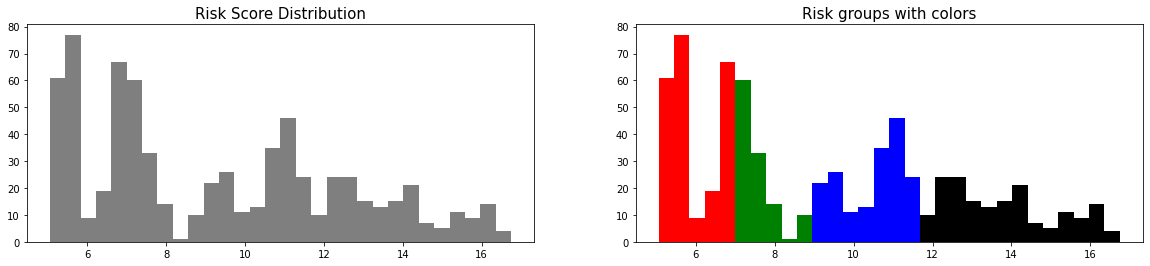

In [605]:
# predictions: customer quartiles, grouped by their risk scores
q1 = df1["risk"].quantile(0.25)
q2 = df1["risk"].quantile(0.50)
q3 = df1["risk"].quantile(0.75)
q4 = df1["risk"].max()
risk_groups = create_risk_groups(
                                    model=model, 
                                    X=X_test,
                                    use_log = False, 
                                    num_bins=30, 
                                    figure_size=(20, 4),
                                    q1={'lower_bound':0,  'upper_bound':q1, 'color':'red'},
                                    q2={'lower_bound':q1, 'upper_bound':q2, 'color':'green'},
                                    q3={'lower_bound':q2, 'upper_bound':q3, 'color':'blue'},
                                    q4={'lower_bound':q3, 'upper_bound':q4, 'color':'black'}
                                )